# t-SNE Visualization: CLIP Features with Different Loss Functions

This notebook visualizes how different **loss functions** affect the learned CLIP feature space.

**What we're comparing:**
- Vanilla CLIP features (no finetuning)
- ArcFace-trained features
- SigLip-trained features
- ArcFaceSigmoid-trained features
- Any other surrogate variants

**Key Question:** Do different loss functions produce better class separation in CLIP's embedding space?

**Expected Result:** ArcFace and similar metric learning losses should produce tighter, more separated clusters compared to vanilla CLIP.

## Setup


In [ ]:
# Cell 1: GPU + Repo Setup
!nvidia-smi
%cd /content

import os
if not os.path.exists("MFCLIP_acv"):
    !git clone -b hamza/discrim https://github.com/1hamzaiqbal/MFCLIP_acv

%cd MFCLIP_acv
!git fetch --all
!git reset --hard origin/hamza/discrim



Tue Nov  4 21:38:06 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   49C    P8             17W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# Cell 2: Install Dependencies
!pip install -q torch torchvision timm einops yacs tqdm opencv-python \
    scikit-learn scipy pyyaml ruamel.yaml pytorch-ignite foolbox \
    pandas matplotlib seaborn wilds ftfy



In [ ]:
# Cell 3: Download Oxford Pets Dataset
from torchvision.datasets import OxfordIIITPet
from torchvision import transforms
from pathlib import Path
import os

root = Path("/content/data/oxford_pets")
root.mkdir(parents=True, exist_ok=True)
_ = OxfordIIITPet(root=str(root), download=True, transform=transforms.ToTensor())
print("✓ Oxford Pets downloaded to", root)

# Also fetch raw images/annotations (needed by DASS dataloader)
%cd /content
if not os.path.exists("/content/data/oxford_pets/images"):
    print("Downloading images and annotations...")
    !wget -q https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
    !wget -q https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
    !tar -xf images.tar.gz -C /content/data/oxford_pets
    !tar -xf annotations.tar.gz -C /content/data/oxford_pets
    !rm -f images.tar.gz annotations.tar.gz
print("✓ Dataset ready!")



Oxford Pets downloaded to /content/data/oxford_pets
/content
list.txt
README
test.txt
trainval.txt
trimaps
xmls


In [ ]:
# Cell 4: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

DRIVE_ROOT = "/content/drive/MyDrive/grad/comp_vision/hanson_loss/oxford_pets"

# List available checkpoints
print("\\nAvailable checkpoints in Drive:")
import os
if os.path.exists(DRIVE_ROOT):
    for f in sorted(os.listdir(DRIVE_ROOT)):
        if f.endswith('.pth') or f.endswith('.pt'):
            size_mb = os.path.getsize(f"{DRIVE_ROOT}/{f}") / 1e6
            print(f"  {f} ({size_mb:.1f} MB)")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Cell 5: Define Checkpoint Paths
# Add your checkpoints here - adjust filenames as needed

CHECKPOINTS = {
    "ArcFace": f"{DRIVE_ROOT}/RN50_ArcFace_oxford_pets.pth",
    "ArcFaceSigmoid": f"{DRIVE_ROOT}/RN50_ArcFaceSigmoid_300ep.pth",
    "SigLip": f"{DRIVE_ROOT}/RN50_SigLipHead_300ep.pth",
}

# Verify which checkpoints exist
print("Checkpoint availability:")
available_checkpoints = {}
for name, path in CHECKPOINTS.items():
    if os.path.exists(path):
        print(f"  ✓ {name}: {path}")
        available_checkpoints[name] = path
    else:
        print(f"  ✗ {name}: {path} (not found)")


['backbone.1.conv1.weight', 'backbone.1.bn1.weight', 'backbone.1.bn1.bias', 'backbone.1.bn1.running_mean', 'backbone.1.bn1.running_var', 'backbone.1.bn1.num_batches_tracked', 'backbone.1.conv2.weight', 'backbone.1.bn2.weight', 'backbone.1.bn2.bias', 'backbone.1.bn2.running_mean', 'backbone.1.bn2.running_var', 'backbone.1.bn2.num_batches_tracked', 'backbone.1.conv3.weight', 'backbone.1.bn3.weight', 'backbone.1.bn3.bias', 'backbone.1.bn3.running_mean', 'backbone.1.bn3.running_var', 'backbone.1.bn3.num_batches_tracked', 'backbone.1.layer1.0.conv1.weight', 'backbone.1.layer1.0.bn1.weight', 'backbone.1.layer1.0.bn1.bias', 'backbone.1.layer1.0.bn1.running_mean', 'backbone.1.layer1.0.bn1.running_var', 'backbone.1.layer1.0.bn1.num_batches_tracked', 'backbone.1.layer1.0.conv2.weight', 'backbone.1.layer1.0.bn2.weight', 'backbone.1.layer1.0.bn2.bias', 'backbone.1.layer1.0.bn2.running_mean', 'backbone.1.layer1.0.bn2.running_var', 'backbone.1.layer1.0.bn2.num_batches_tracked', 'backbone.1.layer1.0.

In [ ]:
# Cell 6: Setup Python Path
import sys
sys.path.insert(0, "/content/MFCLIP_acv/lpclip")
sys.path.insert(0, "/content/MFCLIP_acv")
os.makedirs("/content/MFCLIP_acv/lpclip/datasets", exist_ok=True)
open("/content/MFCLIP_acv/lpclip/datasets/__init__.py", "a").close()
print("✓ Python path configured")


In [ ]:
# Cell 7: Extract Vanilla CLIP Features
%cd /content/MFCLIP_acv

DATA = "/content/data"
FEAT_DIR = "/content/MFCLIP_acv/clip_feat"
SEED = 1

# Extract features for test split (main visualization)
print("Extracting vanilla CLIP features...")
!python -m lpclip.feat_extractor \
  --split test \
  --root "{DATA}" \
  --seed {SEED} \
  --dataset-config-file configs/datasets/oxford_pets.yaml \
  --config-file configs/trainers/CoOp/rn50_val.yaml \
  --output-dir "{FEAT_DIR}" \
  --eval-only

# Confirm artifacts
print("\\n✓ Feature extraction complete!")
!ls -l {FEAT_DIR}/OxfordPets


/content/MFCLIP_acv
***************
** Arguments **
***************
backbone: 
config_file: configs/trainers/CoOp/rn50_val.yaml
dataset_config_file: configs/datasets/oxford_pets.yaml
eval_only: True
head: 
num_shot: 1
output_dir: /content/MFCLIP_acv/clip_feat
root: /content/data
seed: 1
split: train
trainer: 
************
** Config **
************
DATALOADER:
  BS: 128
  K_TRANSFORMS: 1
  NUM_WORKERS: 8
  RETURN_IMG0: False
  TEST:
    BATCH_SIZE: 200
    SAMPLER: SequentialSampler
  TRAIN_U:
    BATCH_SIZE: 32
    N_DOMAIN: 0
    N_INS: 16
    SAME_AS_X: True
    SAMPLER: RandomSampler
  TRAIN_X:
    BATCH_SIZE: 200
    N_DOMAIN: 0
    N_INS: 16
    SAMPLER: RandomSampler
DATASET:
  ALL_AS_UNLABELED: False
  CIFAR_C_LEVEL: 1
  CIFAR_C_TYPE: 
  NAME: OxfordPets
  NUM_LABELED: -1
  NUM_SHOTS: -1
  ROOT: /content/data
  SOURCE_DOMAINS: ()
  STL10_FOLD: -1
  SUBSAMPLE_CLASSES: all
  TARGET_DOMAINS: ()
  VAL_PERCENT: 0.1
INPUT:
  COLORJITTER_B: 0.4
  COLORJITTER_C: 0.4
  COLORJITTER_H: 0.1

In [ ]:
# Cell 8: Define t-SNE Helper Functions
import os, numpy as np, matplotlib.pyplot as plt
import torch
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import pdist, squareform

FEAT_DIR = "/content/MFCLIP_acv/clip_feat/OxfordPets"
OUT_DIR  = "/content/MFCLIP_acv/tsne_results"
os.makedirs(OUT_DIR, exist_ok=True)

def load_npz(split="test"):
    """Load extracted features from .npz file"""
    d = np.load(os.path.join(FEAT_DIR, f"{split}.npz"))
    return d["feature_list"].astype(np.float32), d["label_list"].astype(np.int64)

def torch_load_any(path):
    """Load checkpoint, handling nested state_dict"""
    sd = torch.load(path, map_location="cpu")
    return sd["state_dict"] if isinstance(sd, dict) and "state_dict" in sd else sd

def guess_head_weight(sd, in_dim):
    """Find the projection weight matrix from checkpoint"""
    cands = [(k,v) for k,v in sd.items() if isinstance(v, torch.Tensor) and v.ndim==2]
    for k,v in cands:
        if v.shape[0] == in_dim:
            return v.numpy(), k
    return None, None

def cosine_project(X, W):
    """Project features through weight matrix with cosine normalization"""
    Xn = X / np.maximum(np.linalg.norm(X, axis=1, keepdims=True), 1e-12)
    Wn = W / np.maximum(np.linalg.norm(W, axis=0, keepdims=True), 1e-12)
    return Xn @ Wn

def compute_cluster_metrics(X, y):
    """Compute silhouette score (higher = better clustering)"""
    try:
        return silhouette_score(X, y)
    except:
        return np.nan

def run_single_tsne(X, y, title, perplexity=30):
    """Run t-SNE and return embeddings + metrics"""
    print(f"Running t-SNE for: {title}...")
    Z = TSNE(n_components=2, perplexity=perplexity, random_state=42, init="pca", n_iter=1000).fit_transform(X)
    silhouette = compute_cluster_metrics(Z, y)
    return Z, silhouette

print("✓ Helper functions defined")


Saved: /content/MFCLIP_acv/tsne_vanilla.png


In [ ]:
# Cell 9: Run t-SNE on All Variants
# Load vanilla features
X_vanilla, y = load_npz("test")
print(f"Loaded {len(X_vanilla)} samples with {len(np.unique(y))} classes")
print(f"Feature dim: {X_vanilla.shape[1]}")

# Store all embeddings and metrics
all_results = {}

# 1. Vanilla CLIP (no projection)
Z_vanilla, sil_vanilla = run_single_tsne(X_vanilla, y, "Vanilla CLIP")
all_results["Vanilla CLIP"] = {"embeddings": Z_vanilla, "silhouette": sil_vanilla, "features": X_vanilla}

# 2. Process each available checkpoint
for name, path in available_checkpoints.items():
    print(f"\n--- Processing {name} ---")
    sd = torch_load_any(path)
    W, key = guess_head_weight(sd, X_vanilla.shape[1])
    
    if W is not None:
        print(f"  Using weight: {key} {W.shape}")
        X_proj = cosine_project(X_vanilla, W)
        Z, sil = run_single_tsne(X_proj, y, name)
        all_results[name] = {"embeddings": Z, "silhouette": sil, "features": X_proj}
    else:
        print(f"  ✗ Could not find projection weights")

print(f"\n✓ Processed {len(all_results)} variants")


[ArcFaceSigmoid] using backbone.1.attnpool.c_proj.weight (1024, 2048)
Saved: /content/MFCLIP_acv/tsne_arcfacesigmoid.png


In [ ]:
# Cell 10: Visualize All Variants Side-by-Side
n_variants = len(all_results)
cols = min(n_variants, 3)
rows = (n_variants + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 5*rows), dpi=150)
if n_variants == 1:
    axes = np.array([axes])
axes = axes.flatten()

cmap = plt.cm.get_cmap('tab20', len(np.unique(y)))

for idx, (name, data) in enumerate(all_results.items()):
    ax = axes[idx]
    Z = data["embeddings"]
    sil = data["silhouette"]
    
    scatter = ax.scatter(Z[:, 0], Z[:, 1], c=y, s=10, alpha=0.7, cmap=cmap)
    ax.set_title(f"{name}\n(Silhouette: {sil:.3f})", fontsize=11)
    ax.set_xticks([])
    ax.set_yticks([])

# Hide unused axes
for idx in range(n_variants, len(axes)):
    axes[idx].axis('off')

plt.suptitle("t-SNE: CLIP Features with Different Loss Functions (Oxford Pets)", fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig(f"{OUT_DIR}/tsne_loss_comparison.png", dpi=150, bbox_inches='tight')
plt.show()
print(f"\n✓ Saved to {OUT_DIR}/tsne_loss_comparison.png")


[SigLip] using backbone.1.attnpool.c_proj.weight (1024, 2048)
Saved: /content/MFCLIP_acv/tsne_siglip.png


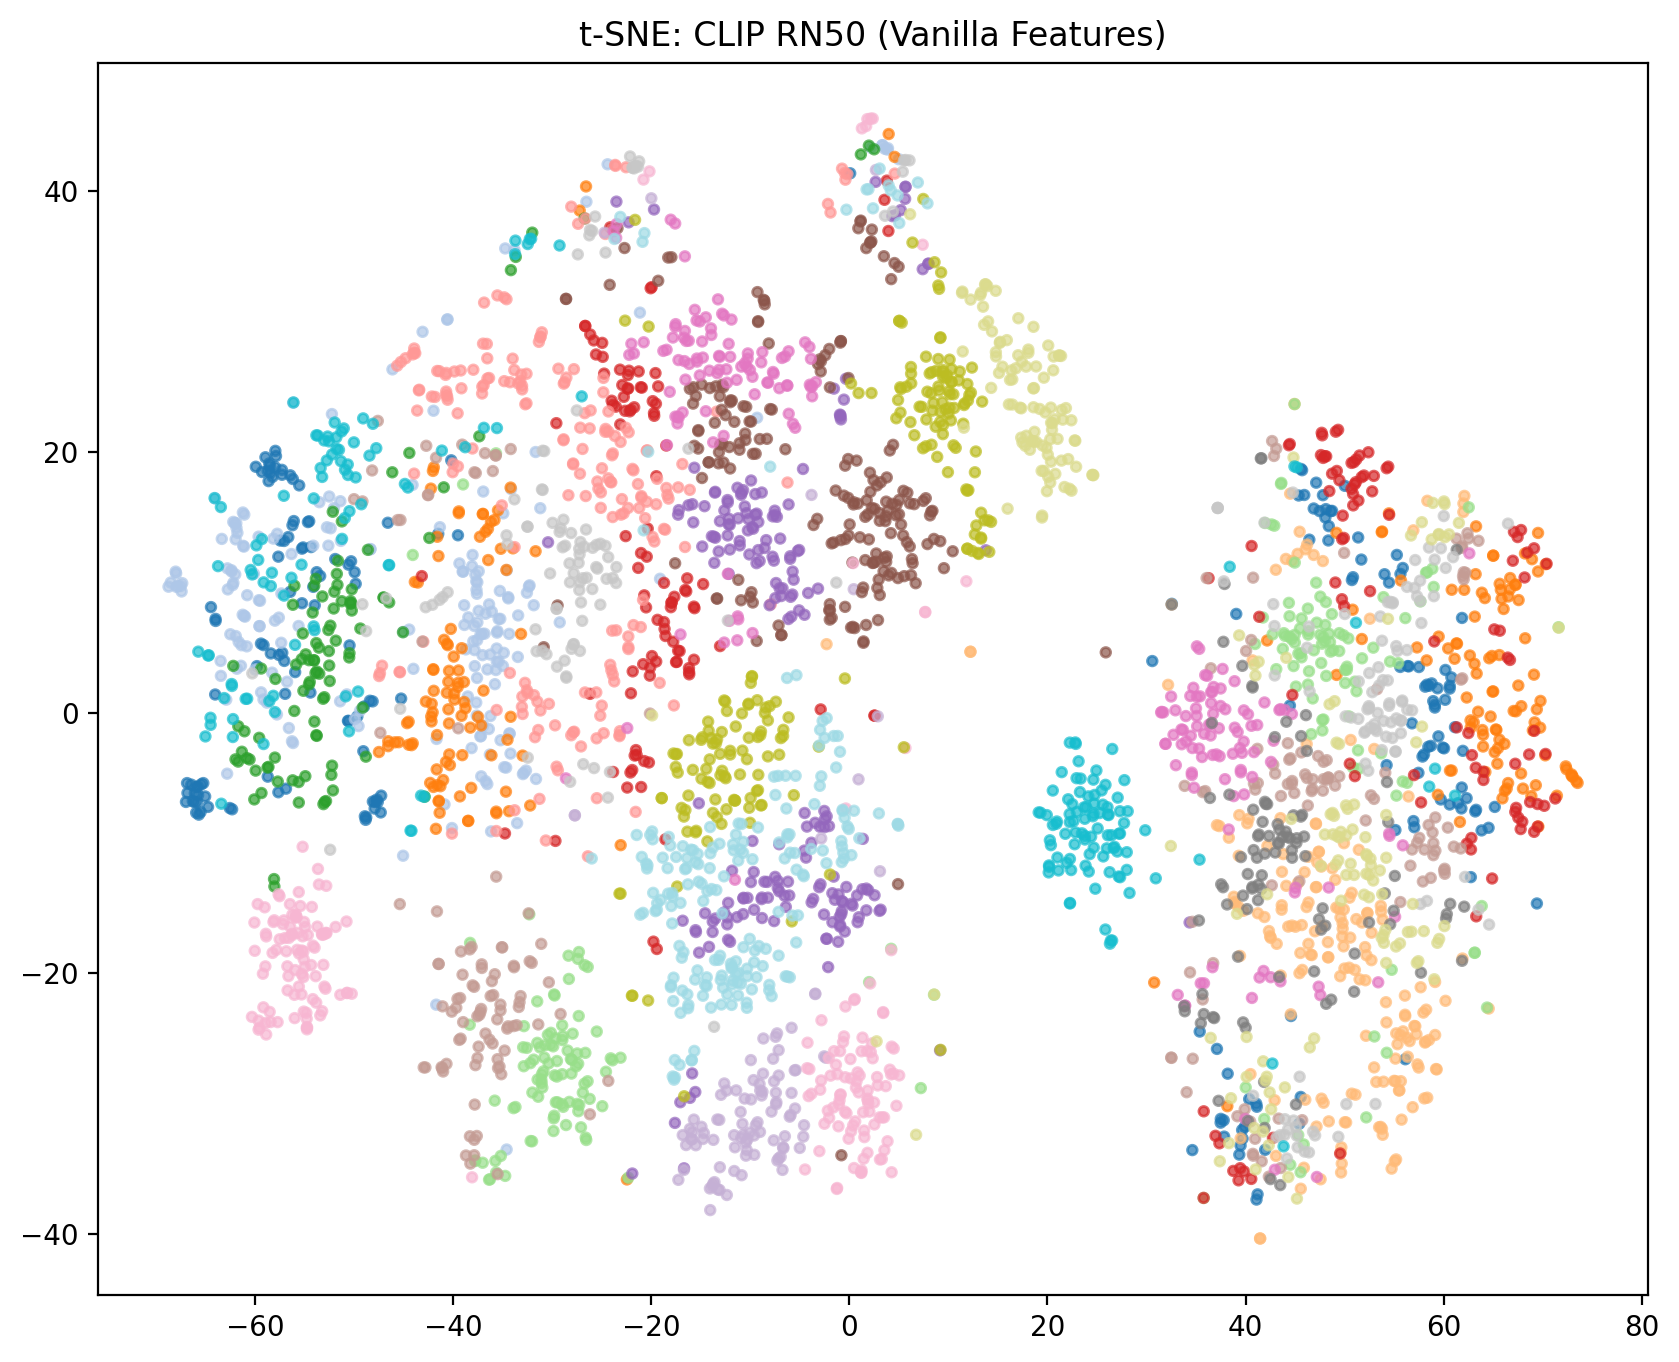

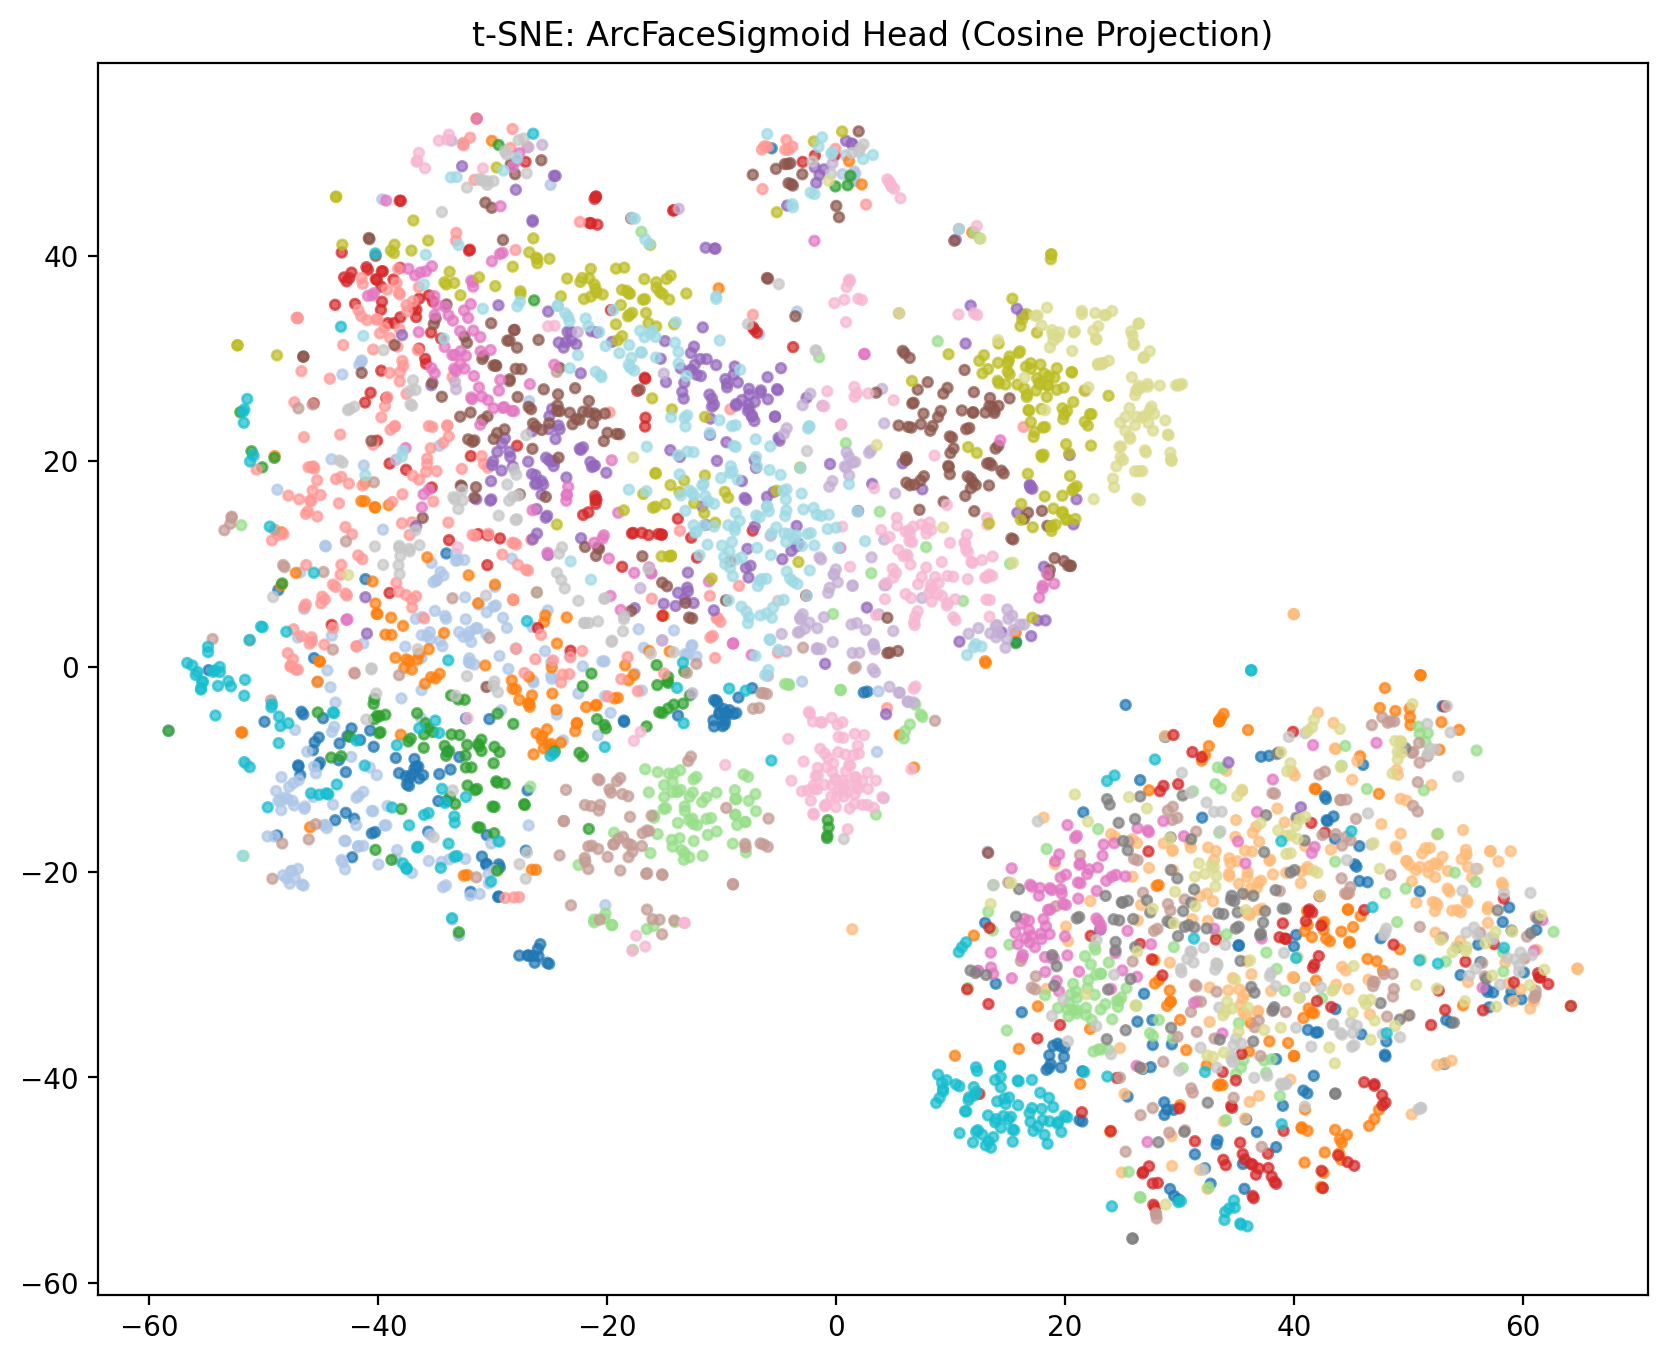

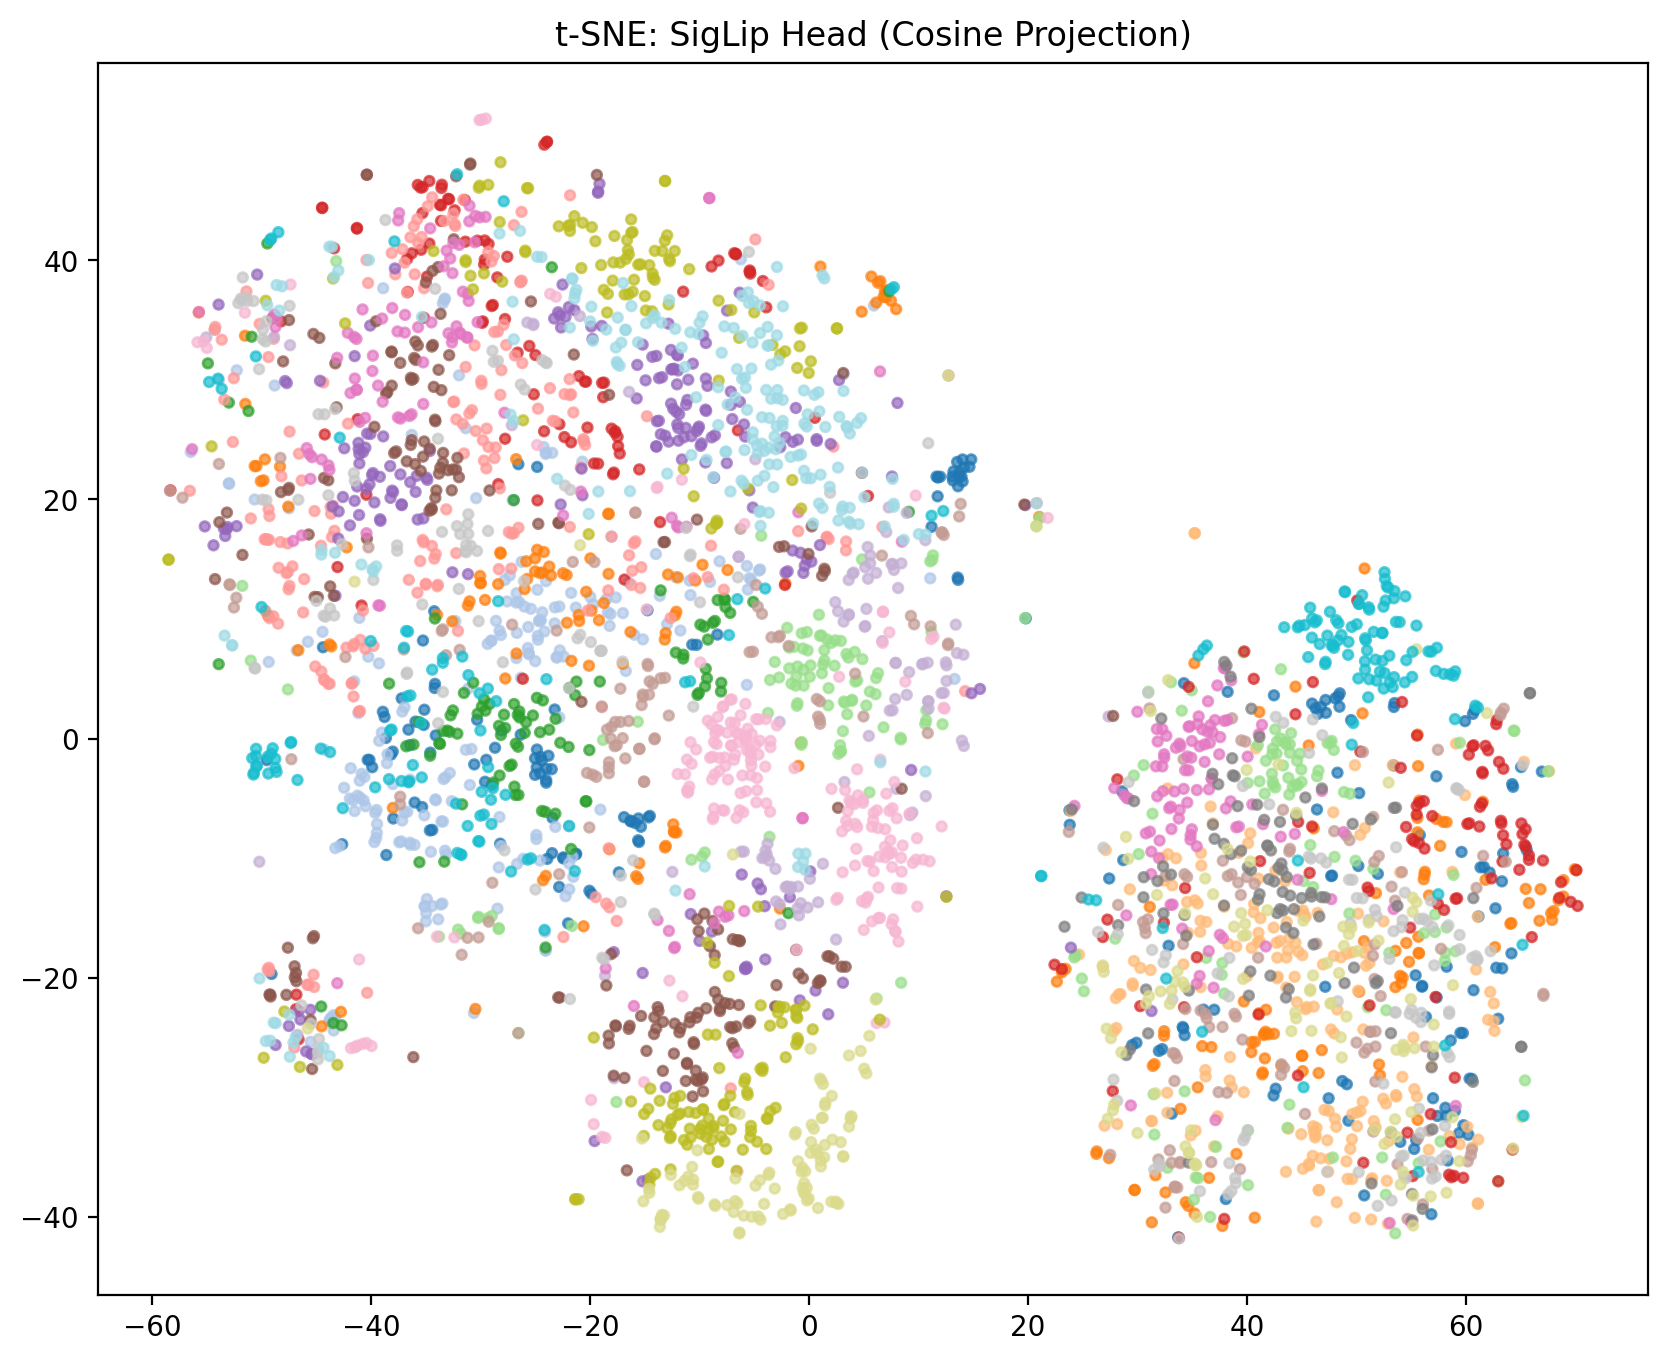

In [ ]:
# Cell 11: Quantitative Metrics Summary
import pandas as pd

# Compute inter-class and intra-class distances
def compute_distance_metrics(X, y):
    """Compute average inter-class and intra-class distances"""
    classes = np.unique(y)
    
    # Intra-class: average distance within same class
    intra_dists = []
    for c in classes:
        mask = (y == c)
        if mask.sum() > 1:
            X_c = X[mask]
            dists = pdist(X_c, 'cosine')
            if len(dists) > 0:
                intra_dists.append(np.mean(dists))
    
    # Inter-class: average distance between class centroids
    centroids = np.array([X[y == c].mean(axis=0) for c in classes])
    inter_dists = pdist(centroids, 'cosine')
    
    return np.mean(intra_dists) if intra_dists else np.nan, np.mean(inter_dists)

# Build results table
results_table = []
for name, data in all_results.items():
    intra, inter = compute_distance_metrics(data["features"], y)
    results_table.append({
        "Loss Function": name,
        "Silhouette Score": data["silhouette"],
        "Intra-class Dist (↓)": intra,
        "Inter-class Dist (↑)": inter,
        "Ratio (↑)": inter / intra if intra > 0 else np.nan
    })

df = pd.DataFrame(results_table)
df = df.sort_values("Silhouette Score", ascending=False)

print("=" * 70)
print("CLIP Feature Quality Metrics (by Loss Function)")
print("=" * 70)
print(df.to_string(index=False))
print("=" * 70)
print("\n↑ = higher is better, ↓ = lower is better")
print("Silhouette Score: -1 to 1, higher = better cluster separation")


In [ ]:
# Cell 12: Plot Metrics Bar Chart
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

names = df["Loss Function"].tolist()
colors = plt.cm.Set2(np.linspace(0, 1, len(names)))

# Silhouette Score
ax = axes[0]
bars = ax.barh(names, df["Silhouette Score"], color=colors)
ax.set_xlabel("Silhouette Score (higher = better)")
ax.set_title("Cluster Quality")
ax.invert_yaxis()

# Inter/Intra Ratio
ax = axes[1]
bars = ax.barh(names, df["Ratio (↑)"], color=colors)
ax.set_xlabel("Inter/Intra Distance Ratio (higher = better)")
ax.set_title("Class Separation")
ax.invert_yaxis()

plt.tight_layout()
plt.savefig(f"{OUT_DIR}/metrics_comparison.png", dpi=150, bbox_inches='tight')
plt.show()


In [ ]:
# Cell 13: Save Results to Google Drive
import shutil

SAVE_DIR = f"{DRIVE_ROOT}/tsne_clip_features"
os.makedirs(SAVE_DIR, exist_ok=True)

# Copy all results
files_to_save = [
    f"{OUT_DIR}/tsne_loss_comparison.png",
    f"{OUT_DIR}/metrics_comparison.png",
]

print(f"Saving results to {SAVE_DIR}...")
for f in files_to_save:
    if os.path.exists(f):
        shutil.copy(f, SAVE_DIR)
        print(f"  ✓ {os.path.basename(f)}")
    else:
        print(f"  ✗ {os.path.basename(f)} (not found)")

# Save metrics table
df.to_csv(f"{SAVE_DIR}/clip_feature_metrics.csv", index=False)
print(f"  ✓ clip_feature_metrics.csv")

print(f"\n✓ All results saved to {SAVE_DIR}")
